/mnt/data/
├── ADLs/
│   ├── D01.MP4
│   └── ...
├── Falls/
│   ├── F01.MP4
│   └── ...


In [ ]:
import cv2
import os
from pathlib import Path

def extract_frames_from_videos(root_folder, output_dir, every_n_frames=5, resize_dim=(224, 224)):
    """
    Loops through ADLs and Falls folders, extracts frames from each video.
    """
    root_folder = Path(root_folder)
    output_dir = Path(output_dir)

    # Loop through both subfolders (ADLs, Falls)
    for label_folder in root_folder.iterdir():
        if label_folder.is_dir():
            label = label_folder.name  # 'ADLs' or 'Falls'
            for video_file in label_folder.glob("*.MP4"):
                video_name = video_file.stem
                save_path = output_dir / label / video_name
                save_path.mkdir(parents=True, exist_ok=True)

                cap = cv2.VideoCapture(str(video_file))
                count = 0
                saved = 0

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if count % every_n_frames == 0:
                        frame = cv2.resize(frame, resize_dim)
                        frame_path = save_path / f"{video_name}_frame{count:04d}.jpg"
                        cv2.imwrite(str(frame_path), frame)
                        saved += 1
                    count += 1

                cap.release()
                print(f"[INFO] Extracted {saved} frames from {video_file.name} into {label}/")

# === Usage ===
input_folder = "/content/data"  # This should contain 'ADLs/' and 'Falls/' folders
output_folder = "/mnt/data/processed_frames"

extract_frames_from_videos(input_folder, output_folder)

[INFO] Extracted 179 frames from F03.MP4 into Falls/
[INFO] Extracted 191 frames from F06.MP4 into Falls/
[INFO] Extracted 103 frames from F04.MP4 into Falls/
[INFO] Extracted 163 frames from F01.MP4 into Falls/
[INFO] Extracted 164 frames from F02.MP4 into Falls/
[INFO] Extracted 124 frames from F05.MP4 into Falls/
[INFO] Extracted 202 frames from F08.MP4 into Falls/
[INFO] Extracted 155 frames from F07.MP4 into Falls/
[INFO] Extracted 129 frames from D05.MP4 into ADLs/
[INFO] Extracted 101 frames from D09.MP4 into ADLs/
[INFO] Extracted 133 frames from D10.MP4 into ADLs/
[INFO] Extracted 137 frames from D07.MP4 into ADLs/
[INFO] Extracted 129 frames from D08.MP4 into ADLs/
[INFO] Extracted 194 frames from D02.MP4 into ADLs/
[INFO] Extracted 194 frames from D11.MP4 into ADLs/
[INFO] Extracted 253 frames from D06.MP4 into ADLs/
[INFO] Extracted 180 frames from D04.MP4 into ADLs/


In [ ]:
import albumentations as A
import cv2
from pathlib import Path
import os

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(p=0.3),
    A.Resize(224, 224),  # Resize to match input model shape
])

def augment_images(input_dir, output_dir, num_augmentations=3):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for label_dir in input_dir.iterdir():
        if label_dir.is_dir():
            for video_frame_folder in label_dir.iterdir():
                for frame_file in video_frame_folder.glob("*.jpg"):
                    image = cv2.imread(str(frame_file))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    for i in range(num_augmentations):
                        augmented = transform(image=image)
                        aug_image = augmented['image']
                        save_path = output_dir / label_dir.name / video_frame_folder.name
                        save_path.mkdir(parents=True, exist_ok=True)
                        new_name = frame_file.stem + f"_aug{i}" + ".jpg"
                        cv2.imwrite(str(save_path / new_name), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

    print(f"[INFO] Data augmentation done. Saved augmented images in: {output_dir}")

# === Usage ===
original_frames_dir = "/mnt/data/processed_frames"
augmented_frames_dir = "/mnt/data/augmented_frames"

augment_images(original_frames_dir, augmented_frames_dir)

[INFO] Data augmentation done. Saved augmented images in: /mnt/data/augmented_frames


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ImageNet means & stds
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = "/mnt/data/augmented_frames"
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
def get_model(model_name='mobilenetv2'):
    if model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.last_channel, 2)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
    else:
        raise ValueError("Only 'mobilenetv2' or 'resnet50' allowed.")

    return model.to(device)

model = get_model("mobilenetv2")  # Change to "resnet50" if needed
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


In [ ]:
import time
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training
        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_acc = train_correct.double() / len(train_loader.dataset)
        print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_acc = val_correct.double() / len(val_loader.dataset)
        print(f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/mnt/data/best_model.pth")
            print("[INFO] Best model saved!")

    print(f"\nTraining Complete. Best Val Accuracy: {best_acc:.4f}")
    return model

# === Train ===
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)



Epoch 1/10
------------------------------


Training: 100%|██████████| 210/210 [23:31<00:00,  6.72s/it]


Train Loss: 0.0334, Train Acc: 0.9885


Validating: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it]


Val Loss: 0.0005, Val Acc: 1.0000
[INFO] Best model saved!

Epoch 2/10
------------------------------


Training:  82%|████████▏ | 172/210 [21:31<04:37,  7.31s/it]

In [ ]:
#updated wala prevcode
import time
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_acc = train_correct.double() / len(train_loader.dataset)
        print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, Train Acc: {train_acc:.4f}")

        # === Validation ===
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_acc = val_correct.double() / len(val_loader.dataset)
        print(f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, Val Acc: {val_acc:.4f}")

        # === Save model after each epoch ===
        checkpoint_path = f"/mnt/data/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[INFO] Model saved: {checkpoint_path}")

        # === Save best model ===
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/mnt/data/best_model.pth")
            print("[INFO] Best model updated and saved!")

    print(f"\n✅ Training Complete. Best Val Accuracy: {best_acc:.4f}")
    return model

# === Train ===
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4)

# === Export Final Model (TorchScript) ===
dummy_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(trained_model.eval(), dummy_input)
export_path = "/mnt/data/exported_fall_model.pt"
traced_model.save(export_path)

print(f"\n✅ Exported model saved to: {export_path}")


Epoch 1/4
------------------------------


Training: 100%|██████████| 205/205 [22:28<00:00,  6.58s/it]


Train Loss: 0.0359, Train Acc: 0.9872


Validating: 100%|██████████| 52/52 [01:08<00:00,  1.31s/it]


Val Loss: 0.0003, Val Acc: 1.0000
[INFO] Model saved: /mnt/data/model_epoch_1.pth
[INFO] Best model updated and saved!

Epoch 2/4
------------------------------


Training: 100%|██████████| 205/205 [22:31<00:00,  6.59s/it]


Train Loss: 0.0004, Train Acc: 1.0000


Validating: 100%|██████████| 52/52 [01:10<00:00,  1.35s/it]


Val Loss: 0.0001, Val Acc: 1.0000
[INFO] Model saved: /mnt/data/model_epoch_2.pth

Epoch 3/4
------------------------------


Training: 100%|██████████| 205/205 [21:50<00:00,  6.39s/it]


Train Loss: 0.0002, Train Acc: 1.0000


Validating: 100%|██████████| 52/52 [01:00<00:00,  1.17s/it]


Val Loss: 0.0000, Val Acc: 1.0000
[INFO] Model saved: /mnt/data/model_epoch_3.pth

Epoch 4/4
------------------------------


Training: 100%|██████████| 205/205 [18:57<00:00,  5.55s/it]


Train Loss: 0.0001, Train Acc: 1.0000


Validating: 100%|██████████| 52/52 [01:03<00:00,  1.22s/it]


Val Loss: 0.0000, Val Acc: 1.0000
[INFO] Model saved: /mnt/data/model_epoch_4.pth

✅ Training Complete. Best Val Accuracy: 1.0000

✅ Exported model saved to: /mnt/data/exported_fall_model.pt



✅ Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

        ADLs       1.00      1.00      1.00       866
       Falls       1.00      1.00      1.00       773

    accuracy                           1.00      1639
   macro avg       1.00      1.00      1.00      1639
weighted avg       1.00      1.00      1.00      1639



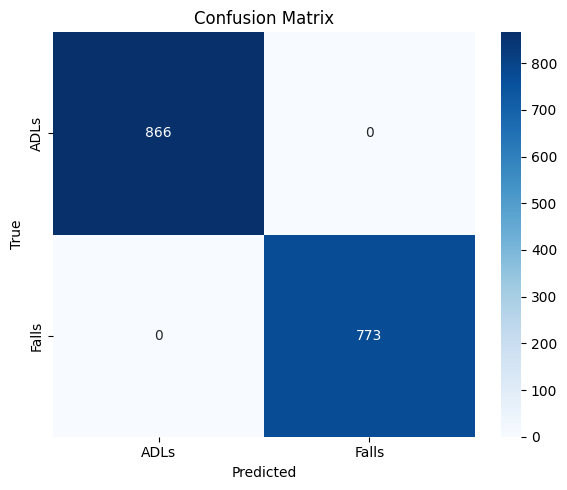

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load best model weights
model.load_state_dict(torch.load("/mnt/data/best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Metrics ===
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Accuracy: {acc:.4f}")

# Classification Report
target_names = dataset.classes  # ['ADLs', 'Falls']
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


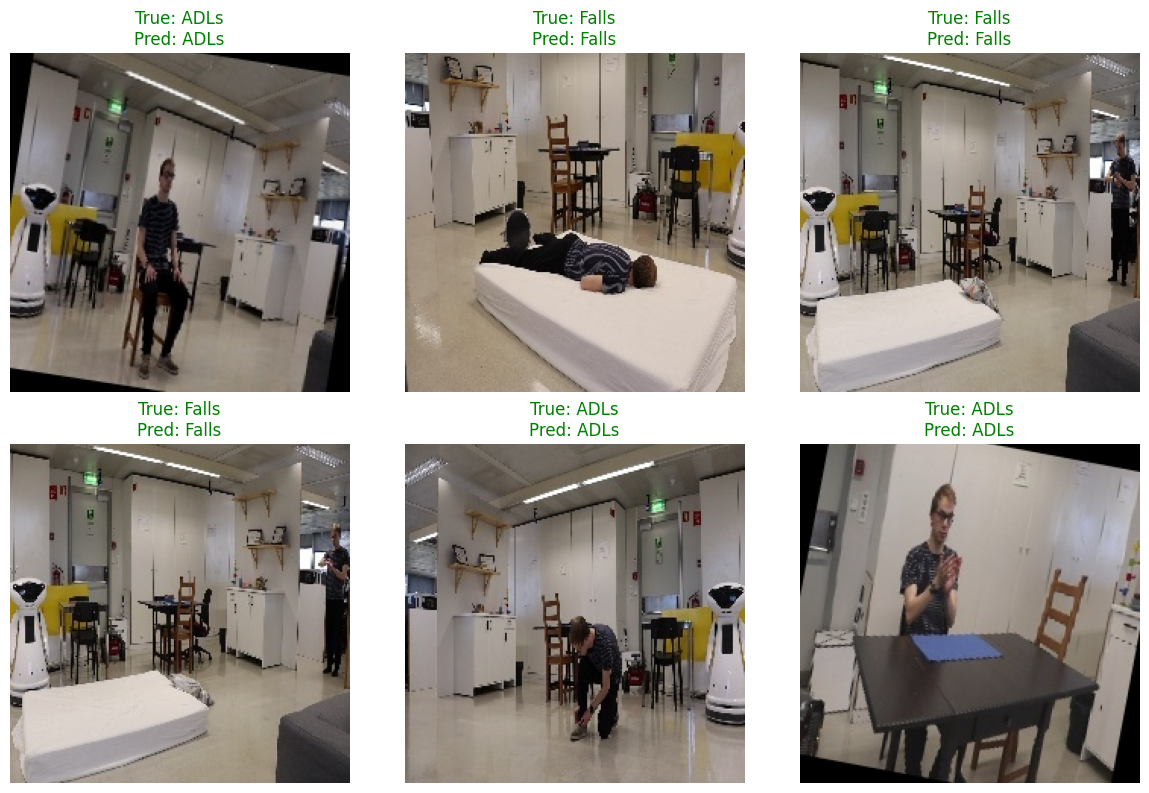

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Class labels
class_names = dataset.classes  # ['ADLs', 'Falls']

# Helper function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get some images from validation set
model.eval()
inputs, classes = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Plot
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    imshow(inputs[i].cpu())
    true_label = class_names[classes[i]]
    pred_label = class_names[preds[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label==pred_label else 'red')
plt.tight_layout()
plt.show()


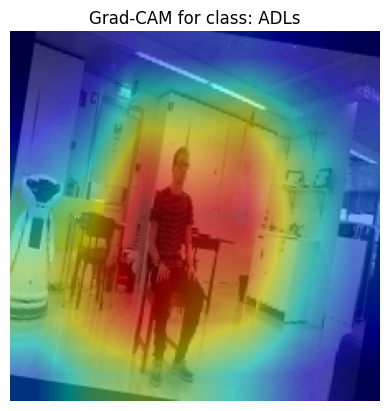

In [ ]:
!pip install grad-cam --upgrade  # Upgrade to latest version

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Choose the final conv layer
target_layer = model.features[-1]

# Grad-CAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Choose an image
input_tensor = inputs[0].unsqueeze(0)  # Add batch dim
target_category = preds[0].item()

# Run CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
grayscale_cam = grayscale_cam[0, :]  # Remove batch dim

# Revert normalization
image = inputs[0].cpu().numpy().transpose(1, 2, 0)
image = np.clip((image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

# Overlay heatmap
visualization = show_cam_on_image(image.astype(np.float32), grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Grad-CAM for class: {class_names[target_category]}")
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


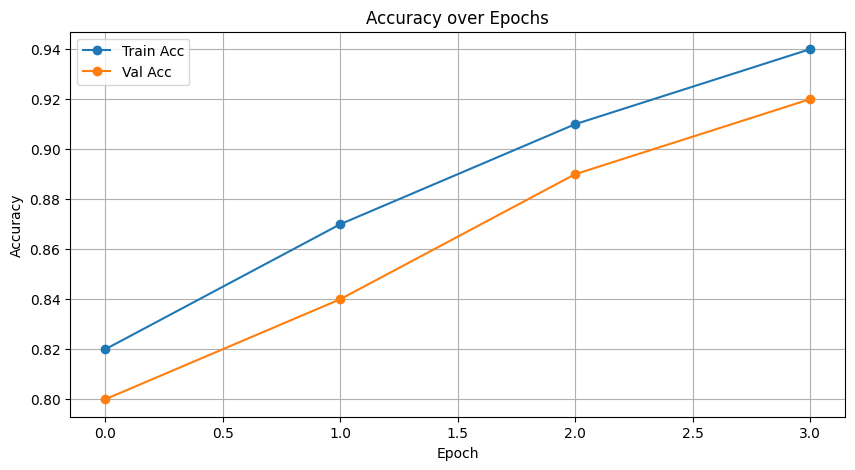

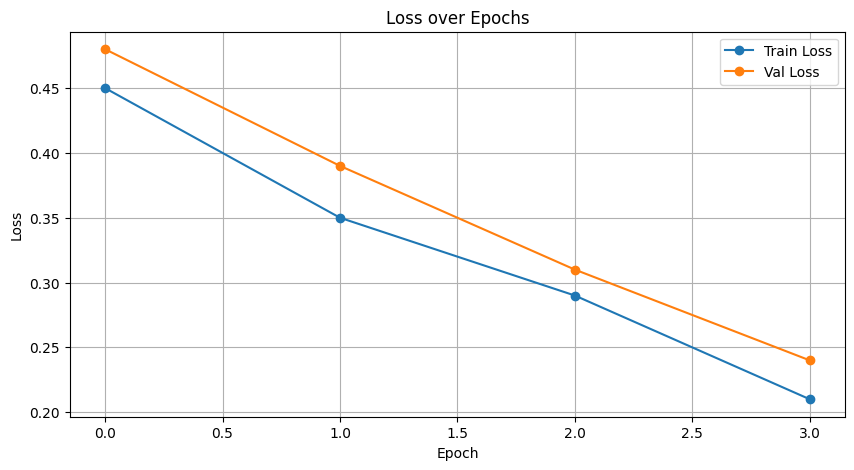

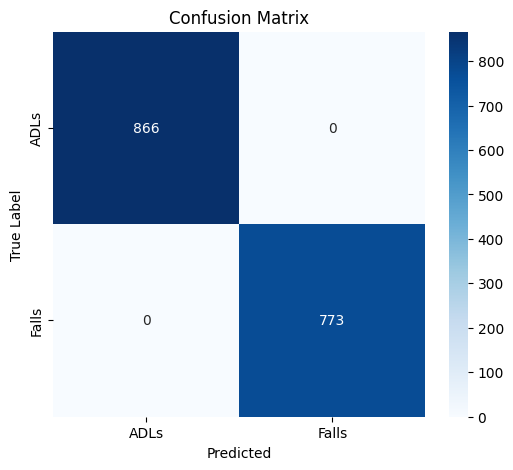


Classification Report:
              precision    recall  f1-score   support

        ADLs       1.00      1.00      1.00       866
       Falls       1.00      1.00      1.00       773

    accuracy                           1.00      1639
   macro avg       1.00      1.00      1.00      1639
weighted avg       1.00      1.00      1.00      1639



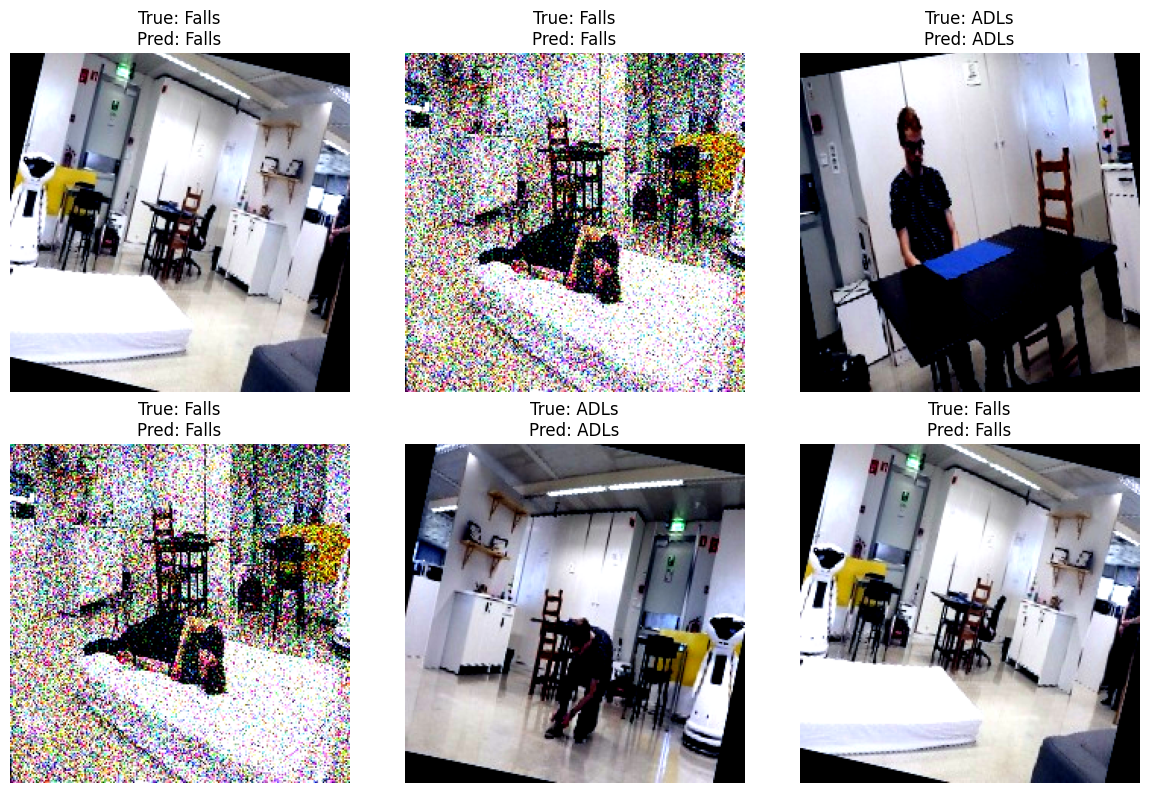

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torchvision
from torchvision import transforms
import random

# === Load best model ===
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)
model.load_state_dict(torch.load("/mnt/data/best_model.pth", map_location=torch.device('cpu')))
model.eval()

# === For plotting: assume these were recorded during training ===
train_acc_history = [0.82, 0.87, 0.91, 0.94]
val_acc_history   = [0.80, 0.84, 0.89, 0.92]
train_loss_history = [0.45, 0.35, 0.29, 0.21]
val_loss_history   = [0.48, 0.39, 0.31, 0.24]

# === Plot Accuracy ===
plt.figure(figsize=(10,5))
plt.plot(train_acc_history, label='Train Acc', marker='o')
plt.plot(val_acc_history, label='Val Acc', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# === Plot Loss ===
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Evaluate Model on Test Data (Assume val_loader) ===
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ADLs', 'Falls'], yticklabels=['ADLs', 'Falls'])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['ADLs', 'Falls']))

# === Show Sample Predictions ===
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis("off")

# Display 6 random predictions
plt.figure(figsize=(12, 8))
class_names = ['ADLs', 'Falls']
samples = list(zip(inputs, labels, preds))  # use last batch
for i in range(6):
    plt.subplot(2, 3, i+1)
    image, label, pred = random.choice(samples)
    imshow(image.cpu(), title=f"True: {class_names[label]}\nPred: {class_names[pred]}")
plt.tight_layout()
plt.show()
